In [2]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
CELEB_IMS_DIR = '../data/celeba-hq/ims/'
CELEB_ANNO_DIR = '../data/celeba-hq/Anno/'
os.listdir(CELEB_IMS_DIR)

In [10]:
ids = pd.read_csv(oj(CELEB_ANNO_DIR, 'identity_CelebA.txt'), delim_whitespace=True, header=None)
ids = ids.rename(columns={0: 'fname', 1: 'id'})

In [11]:
ids.head()

,fname,id
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [24]:
(vals, counts) = np.unique(ids.id.values, return_counts=True)

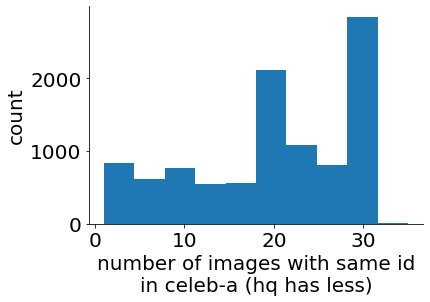

In [31]:
plt.hist(counts)
plt.xlabel('number of images with same id\nin celeb-a (hq has less)')
plt.ylabel('count')
plt.show()